# `ExIFFI` and `EIF+` Tutorial Notebook

This notebook is intended to provide a tutorial on the usage of the `EIF+` and `ExIFFI` algorithms introduced in the paper *ExIFFI and EIF+: Interpretability and Enhanced Generalizability to Extend the Extended Isolation Forest*.

It is possible to recreate the conda environment with all the dependencies needed to run this notebook from the `exiffi_env.yml` file using the following command:

```bash
conda env create -f exiffi_env.yml
```


Import needed packages

In [1]:
import os 
import sys
sys.path.append('../')
from utils_reboot.datasets import Dataset
from utils_reboot.utils import *
from utils_reboot.experiments import *
from utils_reboot.plots import *
from model_reboot import *
import numpy as np

2024-05-10 09:37:01.993643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import Data

Set up some useful paths

In [2]:
os.chdir('../')
cwd=os.getcwd()
data_syn_path=cwd+'/data/syn/'
data_real_path=cwd+'/data/real/'
experiment_path=cwd+'/experiments/results'

Import the dataset using the `Dataset` class from the `datasets` module. If the dataset has more than 7500 samples it will be downsampled to 7500 samples.

For this example we will use the `wine` Real World Dataset. To change the dataset change the first argument of the `Dataset` class to the desired dataset name. The dataset names correspond to the names of the files contained in `data/real/` or `data/syn` folders.

In [15]:
dataset = Dataset('wine', path = data_real_path, feature_names_filepath='data/')
dataset.drop_duplicates()

if dataset.shape[0] > 7500:
    dataset.downsample(max_samples=7500)

### Select Scenario and pre_process

- Scenario 1 → Train and test on the entire dataset
- Scenario 2 → Train solely on the inliers and test on the entire dataset

Suggestion: Pre process the dataset for Real Word datasets (contained in `/data/real`) and do not pre process Synthetic datasets (contained in `/data/syn`)

In [21]:
scenario=select_pre_process_scenario(dataset)

Dataset pre processed

Scenario: 2

X_train shape: (119, 13)
X_test shape: (129, 13)


### Define `EIF+` model

For the sake of this example we will use the `EIF+` model with the default parameters. For all the details about the input parameters please refer to the `ExtendedIsolationForest` class contained in `model_reboot/EIF_reboot.py` or to the Models section in the documentation. 

In [5]:
I=ExtendedIsolationForest(1)

## Performance Metrics Computation

Exploiting the `performance` function it is possible to obtain a Classification report for the input dataset and the `EIF+` model. The resulting values may be sligthly different from the ones reported on the paper because of the intrinsic stochasticity in the `EIF+` model. 

In [6]:
I.fit(dataset.X_train)
score=I.predict(dataset.X_test)
y_pred=I._predict(dataset.X_test,p=dataset.perc_outliers)
performance_metrics,_=performance(y_pred=y_pred,
                                       y_true=dataset.y_test,
                                       score=score,
                                       I=I,
                                       model_name=I.name,
                                       dataset=dataset,
                                       contamination=dataset.perc_outliers,
                                       scenario=scenario,
                                       save=False)
performance_metrics.T

100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


,2024-05-10 09:38:58.171460
Model,EIF+
Dataset,wine
Contamination,0.077519
Train Size,0.8
Precision,0.8
Recall,0.8
f1 score,0.8
Accuracy,0.968992
Balanced Accuracy,0.891597
Average Precision,0.840966


## Adding interpretability with `ExIFFI`

At this point we can evaluate the importances of each feature in the detection of anomalies through the `ExIFFI` model.

### Compute Global Importances

Compute the Global Importances vector and save it into a `.npz` file in the path:

`ExIFFI/experiments/results/dataset_name/experiments/global_importances/model_name/interpretation_name/scenario/`

In [8]:
interpretation="EXIFFI+"
path_gfi=os.path.join(experiment_path,
                  dataset.name,
                  'experiments',
                  'global_importances',
                  I.name,
                  interpretation,
                  f'scenario_{str(scenario)}'
                  )
if not os.path.exists(path_gfi):
    os.makedirs(path_gfi)

full_importances,_ = experiment_global_importances(I, 
                                                   dataset, 
                                                   n_runs=40, 
                                                   p=0.1, 
                                                   interpretation=interpretation) 
save_element(full_importances, path_gfi, filetype="npz")

100%|██████████| 40/40 [00:14<00:00,  2.77it/s]


### Bar Plot

The importance matrix generated in the previous cell is now used to produce the Bar Plot. If the argument `save_image` is set to `True` the plot is saved in the path: `ExIFFI/experiments/results/dataset_name/plots_new/imp_plots/`

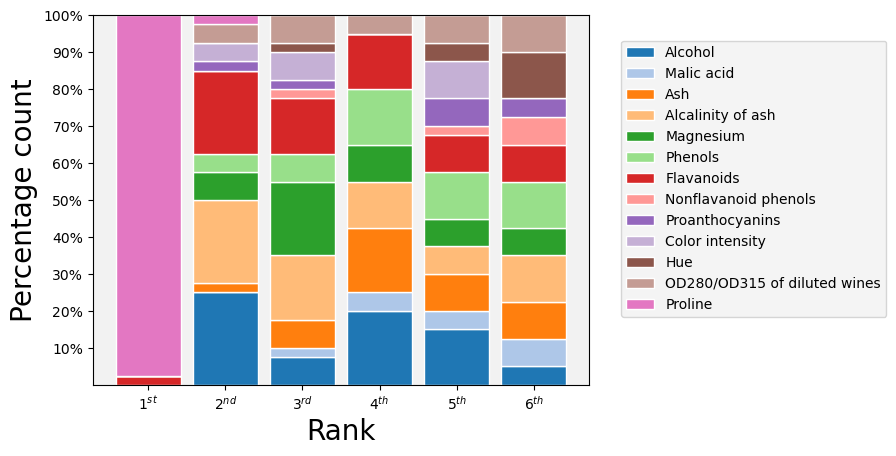

In [16]:
path_plots=os.path.join(experiment_path,dataset.name,'plots_new','imp_plots')
if not os.path.exists(path_plots):
    os.makedirs(path_plots)

most_recent_file = get_most_recent_file(path_gfi,filetype="npz")
_,_,_=bar_plot(dataset, 
         most_recent_file, 
         filetype="npz", 
         plot_path=path_plots, 
         f=min(dataset.shape[1],6),
         show_plot=True,
         model=I, 
         interpretation=interpretation, 
         scenario=scenario,
         save_image=False)


### Score Plot 

Use the Global Importances file most recently calculated to obtain the Score Plot. If the argument `save_image` is set to `True` the plot is saved in the path: `ExIFFI/experiments/results/dataset_name/plots_new/imp_plots/`

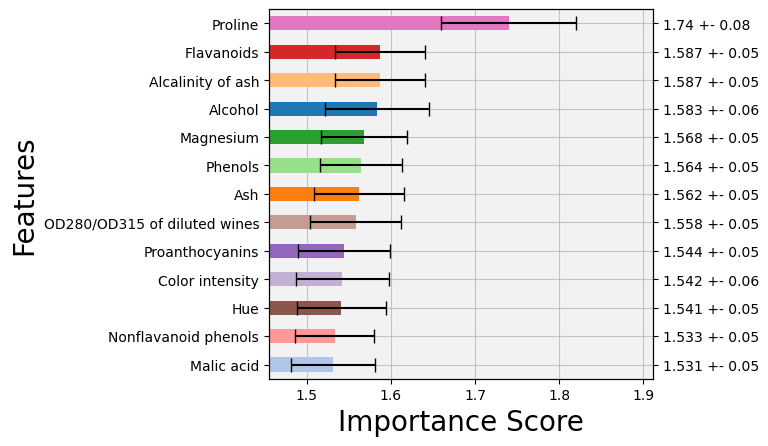

In [17]:
_,_=score_plot(dataset,
           most_recent_file,
           plot_path=path_plots,
           show_plot=True,
           model=I,
           interpretation=interpretation,
           scenario=scenario,
           save_image=False)

### Local Scoremaps

Hint: Use the top 2 features in terms of Importance to obtain the Local Scoremaps. If the argument `save_image` is set to `True` the plot is saved in the path: `ExIFFI/experiments/results/dataset_name/plots_new/local_scoremaps/`

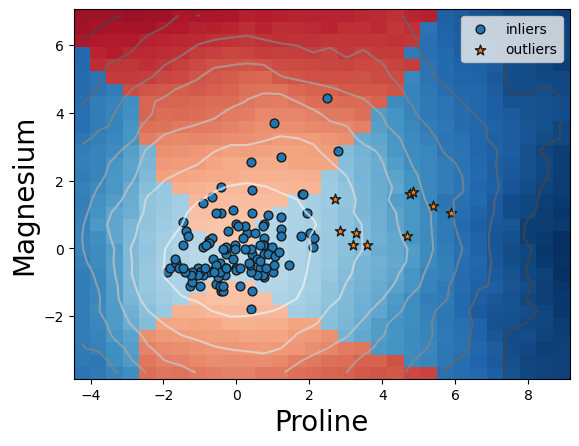

In [22]:
path_plots_local=os.path.join(experiment_path,dataset.name,'plots_new','local_scoremaps')
if not os.path.exists(path_plots_local):
    os.makedirs(path_plots_local)
    
feature1="Proline"
feature2="Magnesium"
feats_plot=get_feature_indexes(dataset,feature1,feature2)
importance_map(dataset=dataset,
               model=I,
               feats_plot=feats_plot,
               path_plot=path_plots_local,
               col_names=dataset.feature_names,
               interpretation=interpretation,
               scenario=scenario,
               save_plot=False)

## Feature Selection Plot

Unsupervised Feature Selection is used as a proxy task for the evaluation of the efficacy of the `EXIFFI` interpretation algorithm in both a qualitative (Feature Selection Plot) and quantitative manner ($AUC_{FS}$ metric). 

In order to obtain the Feature Selection plot we need to use the `.npz` file containing the Global Importances vector computed by `EXIFFI` to order the features in decreasing order of importance. 

In this case the `EIF+` model will be used to compute the Average Precisions (variable `I`) and the `EIF+` model will be the ones interpreted by `ExIFFI` (variable `model_interpretation`). It is possible to set `model_interpretation` also to `IF` or `EIF` to interpret also these models.

The Average Precisions needed to create the plot will be saved in path: 

`ExIFFI/experiments/results/dataset_name/experiments/feature_selection/model_name/model_interpretation_interpretation/scenario/`

In [23]:
model_interpretation='EIF+'
path_plots_fs=os.path.join(experiment_path,dataset.name,'plots_new','fs_plots')
if not os.path.exists(path_plots_fs):
    os.makedirs(path_plots_fs)

matrix = open_element(most_recent_file,filetype="npz")
# Order the features in decreasing order of importance
feat_order = np.argsort(matrix.mean(axis=0))
Precisions = namedtuple("Precisions",["direct","inverse","dataset","model","value"])

# Compute the Average Precisions for the different sets of features
direct = feature_selection(I, dataset, feat_order, 10, inverse=False, random=False, scenario=scenario)
inverse = feature_selection(I, dataset, feat_order, 10, inverse=True, random=False, scenario=scenario)
value = abs(np.nansum(np.nanmean(direct,axis=1)-np.nanmean(inverse,axis=1)))
data = Precisions(direct, inverse, dataset.name, I.name, value)
path_fs=os.path.join(experiment_path,
                  dataset.name,
                  'experiments',
                  'feature_selection',
                  I.name,
                  f'{model_interpretation}_{interpretation}',
                  f'scenario_{str(scenario)}'
                  )
save_fs_prec(data, path_fs)


100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


Compute the Average Precision of a random Feature Selection approach to have a baseline

In [24]:
Precisions_random = namedtuple("Precisions_random",["random","dataset","model"])
random = feature_selection(I, dataset, feat_order, 10, inverse=True, random=True, scenario=scenario)
data_random = Precisions_random(random, dataset.name, I.name)
path_random=os.path.join(experiment_path,
                  dataset.name,
                  'experiments',
                  'feature_selection',
                  I.name,
                  'random',
                  f'scenario_{str(scenario)}'
                  )
save_fs_prec_random(data_random, path_random)

100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


Use the Average Precisions computed in the two previous cells to produce the Feature Selection plot. If the argument `save_image` is set to `True` the plot is saved in the path: `ExIFFI/experiments/results/dataset_name/plots_new/fs_plots/`

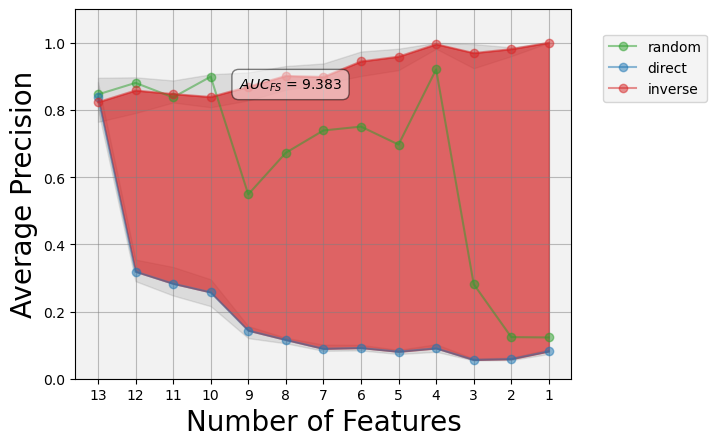

In [28]:
fs_prec = get_most_recent_file(path_fs)
fs_prec_random = get_most_recent_file(path_random)
plot_feature_selection(fs_prec,
                        path_plots, 
                        fs_prec_random, 
                        model=model_interpretation, 
                        eval_model=I.name, 
                        interpretation=interpretation, 
                        scenario=scenario, 
                        plot_image=True,
                        change_ylim=True,
                        save_image=False)